In [95]:
import numpy 
import random

import torch
from torch import nn
import torch.nn.functional as F

import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
from os import path

import torchvision
from torchvision.transforms import v2

from PIL import Image

from tqdm import tqdm

import time

## Обработка датасета

- Таргет в data/label.json
- Изображения в data/images/

### Особенности обработки

- Добавлена аугментация -- зеркальное отражение по горизонтали, с соответсвующим изменениием поворота
- Изображения нормализованы, с помощью mean и std полученных в ходе EDA
- Датасет разбит на 3 части:
  - Тренировочную -- 28000 картинок, на ней будут обучаться модели
  - Валидационную -- 6000 картинок, на ней будет выбираться лучшая модель
  - Тестовую -- 6000 картинок, на ней будут рассчитываться финальные метрики

In [96]:
with open('data/label.json', 'r') as f:
    labels = json.load(f)

labels = torch.tensor(labels)

In [97]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, datadir, transforms):
        self.datadir = datadir
        with open(path.join(datadir, 'label.json')) as f:
            labels = json.load(f)
        self.labels = torch.tensor(labels)
        self.transforms = transforms

    def __len__(self):
        return len(labels)

    def __getitem__(self, ind):
        img = Image.open(path.join(self.datadir, 'images', f'{ind}.jpg'))
        return self.transforms(img), self.labels[ind:ind+1]

In [98]:
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transforms_tgt=None):
        self.subset = subset
        self.transforms_tgt = transforms_tgt
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transforms_tgt:
            x, y = self.transforms_tgt(x, y)
        return x, y
        
    def __len__(self):
        return len(self.subset)

class RandomHorizontalFlipWithTarget(torchvision.transforms.v2.RandomHorizontalFlip):
    def __init__(self, p=0.5):
        super().__init__(p=p)
    
    def forward(self, image, target):
        if random.random() < self.p:
            image = torchvision.transforms.functional.hflip(image)
            target = -target  # Меняем знак целевой переменной
        return image, target

In [99]:
transforms = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=(0.4615, 0.4610, 0.4372), 
        std=(0.2487, 0.2444, 0.2607),
    ),
])

transforms_tgt = RandomHorizontalFlipWithTarget(p=0.5)

dataset = ImageDataset('data', transforms)

dataset_train, dataset_val, dataset_test = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15], generator=torch.Generator().manual_seed(42))

dataset_train = TransformedDataset(dataset_train, transforms_tgt)
dataset_val = TransformedDataset(dataset_val)
dataset_test = TransformedDataset(dataset_test)

In [100]:
batch_size = 128

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=batch_size,
    worker_init_fn=seed_worker,
    generator=torch.Generator().manual_seed(42),
    num_workers=8
)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=8)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=8)

## Код для тренировки нейронной сети

- train_epoch -- одна эпоха обучения
- val_epoch -- одна эпоха валидации
- train -- последовательость эпох обучения и валидации с логгированием и контролем переобучения

In [8]:
def if_tqdm(itr, flag):
    return tqdm(itr) if flag else itr

def train_epoch(model, optimizer, criterion, dataset_train, device, use_tqdm=True):
    mean_loss = 0; n = 0
    
    model.train()
    
    for batch in if_tqdm(dataset_train, use_tqdm):
        optimizer.zero_grad()
        x, y = batch
        x = x.to(device); y = y.to(device)
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        
        mean_loss = mean_loss + loss.item() * len(y)
        n += len(y)

    mean_loss /= n
    
    return mean_loss
    

def val_epoch(model, dataset_val, metrics, device, use_tqdm=True, save_values=False):
    mdict = {metric: 0.0 for metric in metrics}
    n = 0

    if save_values:
        all_trues = []
        all_preds = []

    model.eval()
    for batch in if_tqdm(dataset_val, use_tqdm):
        x, y = batch
        x = x.to(device); y = y.to(device)
        with torch.no_grad():
            preds = model(x)
            
        for metric in metrics:
            mdict[metric] = mdict[metric] + metrics[metric](preds, y).item() * len(y)

        if save_values:
            all_trues.append(y.detach().cpu().squeeze())
            all_preds.append(preds.detach().cpu().squeeze())
            
        n += len(y)

    mdict = {m: mdict[m] / n for m in mdict}

    if save_values:
        all_trues = torch.cat(all_trues)
        all_preds = torch.cat(all_preds)
        return mdict, all_trues, all_preds
        

    return mdict

In [9]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train(
    n_epochs, 
    name, 
    model, 
    optimizer, 
    criterion, 
    scheduler, 
    metrics, 
    dataset_train, 
    dataset_val, 
    watched_metric, 
    device=None, 
    verbose=2,
    max_time=None, 
    max_wait=None,
):
    logs = []
    bests = {
        'epoch': None,
        'metric': None,
    }

    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    if max_time is not None:
        start = time.time()
    
    model.to(device)
    
    for epoch in if_tqdm(range(1, n_epochs+1), verbose == 1):
        if verbose == 2:
            print(f'Epoch {epoch}')
        train_loss = train_epoch(model, optimizer, criterion, dataset_train, device, verbose == 2)
        if scheduler:
            scheduler.step(train_loss)
        if verbose == 2:
            print(f'  Train loss: {train_loss:.4f}')
            
        val_metrics = val_epoch(model, dataset_val, metrics, device, verbose == 2)
        if verbose == 2:
            for metric in val_metrics:
                print(f'  Val   {metric}: {val_metrics[metric]:.4f}')
            print()

        if bests['metric'] is None or val_metrics[watched_metric] < bests['metric']:
            bests['epoch'] = epoch
            bests['metric'] = val_metrics[watched_metric]
            torch.save(model.state_dict(), f'{name}_best.ckpt')

        log_epoch = {
            'epoch': epoch,
            'lr': get_lr(optimizer),
            'train_loss': train_loss,
        }
        for metric in val_metrics:
            log_epoch[f'val_{metric}'] = val_metrics[metric]

        logs.append(log_epoch)

        with open(f'{name}_logs.json', 'w') as f:
            json.dump(logs, f)

        if max_time is not None:
            end = time.time()
            if end - start > max_time:
                break

        if max_wait is not None and epoch - bests['epoch'] > max_wait:
            break

    return bests, logs

## Бейзлайн

Очень простая свёрточная сеть с одним свёрточным слоем и одни скрытым полносвязным.
Мотивация -- свёрточный слой выделят линии разного наклона, глобальный пулинг выделяет средний наклон линий, последний линейный слой вычисляет угол из наклона.

Бейзлайн нужен чтобы:

1. Проверить что всё работает.
2. Иметь что-то простое, но рабочее, с чем сравнивать более сложные модели

In [2]:
class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.inner = nn.Sequential(
            nn.Conv2d(3, 64, 7),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, x):
        return self.inner(x)

In [10]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = BaseModel()

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.L1Loss()
metrics = {
    'loss': nn.L1Loss()
}

In [12]:
bests, logs = train(200, 'baseline', model, optimizer, criterion, scheduler, metrics, dataloader_train, dataloader_val, 'loss', verbose=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [38:02<00:00, 11.41s/it]


In [13]:
import matplotlib.pyplot as plt

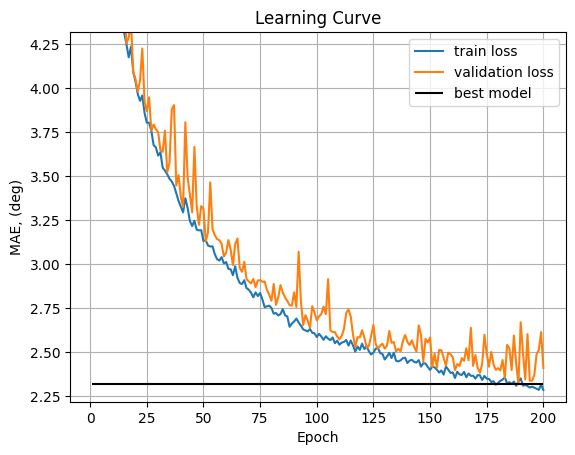

In [14]:
plt.plot([x['epoch'] for x in logs], [x['train_loss'] for x in logs], label='train loss')
plt.plot([x['epoch'] for x in logs], [x['val_loss'] for x in logs], label='validation loss')
plt.hlines(bests['metric'], 1, len(logs), color='black', label='best model')
plt.legend()
plt.ylim(bests['metric'] - 0.1, bests['metric'] + 2)
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('MAE, (deg)')
plt.title('Learning Curve')
plt.show()

### Анализ кривой обучения

- Есть небольшое переобучение (validation loss > train loss)
- Модель близка к плато но не совсем на него вышла, возможно имело смысл учить дольше или увеличить learning rate

In [15]:
model.load_state_dict(torch.load('baseline_best.ckpt', weights_only=True))
model.eval().to('cuda' if torch.cuda.is_available() else 'cpu');

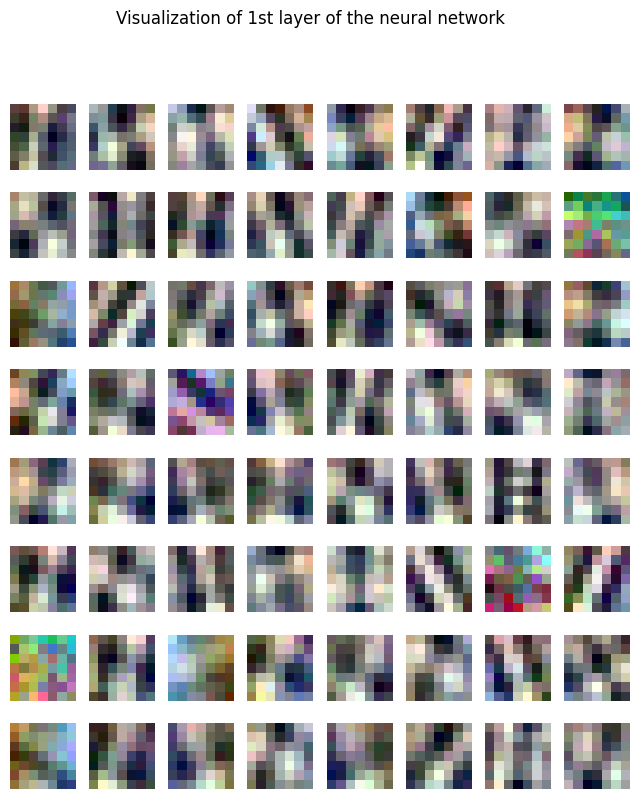

In [16]:
fig = plt.figure(figsize=(8, 9))
fig.suptitle('Visualization of 1st layer of the neural network')
ax = fig.subplots(8, 8)

for i in range(8):
    for j in range(8):
        x = model.inner[0].weight[i * 8 + j].detach().permute((1, 2, 0)).cpu().numpy()
        x = (x - x.min()) / (x.max() - x.min())
        ax[i, j].imshow(x)
        ax[i, j].axis('off')

plt.show()

### Анализ свёрточных фильтров

- Видно, что, на фильтрах есть различные линии идущие под разными углами, где-то линии тёмные, где-то светлые, часть фильтров имеют цветовые переходы
- Три фильтра состоят из чего-то похожего на шум, возможно они что-то выделяют, а может это артефакт недообучения сети

In [17]:
test_metrics = val_epoch(model, dataloader_test, metrics, 'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Test loss: {test_metrics["loss"]:.4f}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 33.66it/s]

Test loss: 2.2612


### MAE на тестовой выборке для бейзлайна 2.2612

In [18]:
_, all_trues, all_preds = val_epoch(model, dataloader_test, metrics, 'cuda' if torch.cuda.is_available() else 'cpu', save_values=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 34.60it/s]


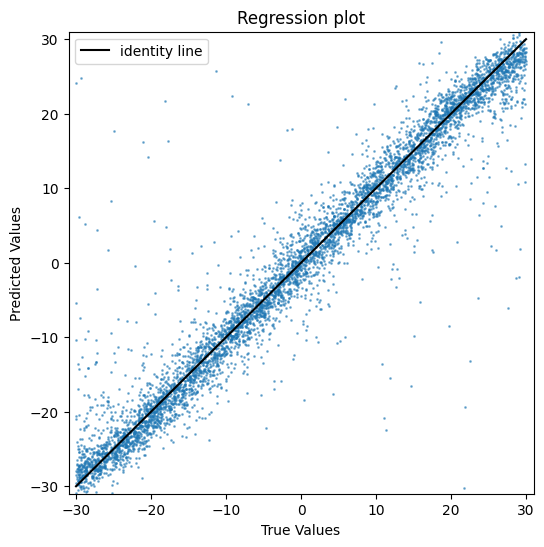

In [19]:
plt.figure(figsize=(6, 6))
plt.scatter(all_trues, all_preds, s=1, alpha=0.5)
plt.plot([-30, 30], [-30, 30], color='black', label='identity line')
plt.xlim(-31, 31)
plt.ylim(-31, 31)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Regression plot')
plt.legend()
plt.show()

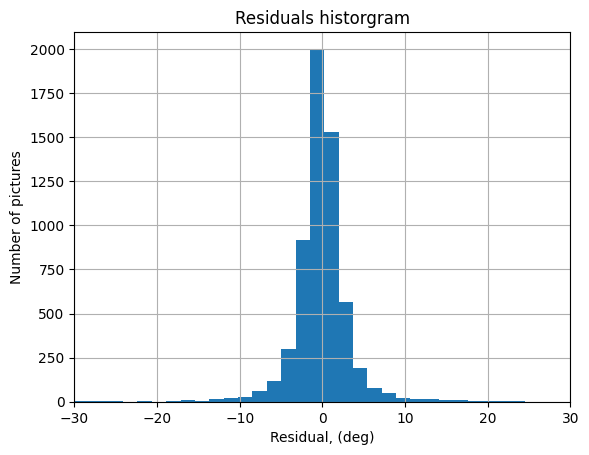

In [20]:
residuals = (all_preds - all_trues)

plt.hist(residuals, bins=61)
plt.xlim(-30, 30)
plt.title('Residuals historgram')
plt.xlabel('Residual, (deg)')
plt.ylabel('Number of pictures')
plt.grid(True)

### Анализ графика регрессии и гистограммы остатков

Для большинства изображений нейроная сеть определяет угол правильно, с погрешностью в пределах 5 градусов, однако для небольшого количества изображений показания сети сильно отличаются от истины, нейронная сеть не имеет предпочтительного знака для ошибки, а также примерно одинаково сильно ошибается как при больших так и при малых углах, однако при углах стремящихся к +30 или -30 если небольшая систематическая погрешность заключающаяся в том что сеть занижает абсолютное значение угла

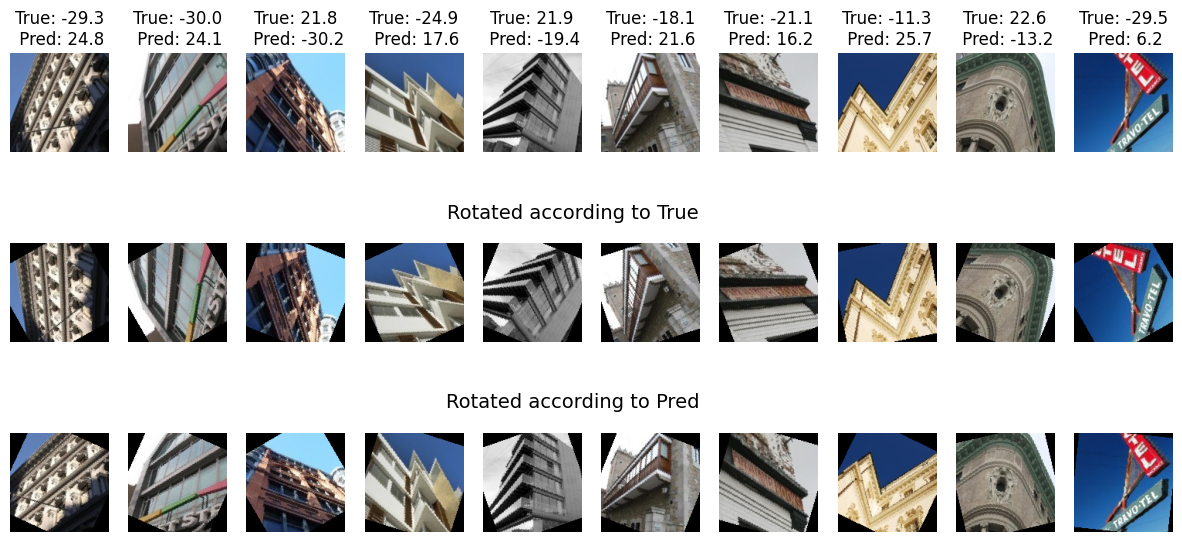

In [21]:
k = 10

top_errors = (all_trues - all_preds).abs().topk(k).indices

index = torch.tensor(dataset_test.subset.indices)[top_errors]

fig = plt.figure(figsize=(15, 7))
ax = fig.subplots(3, 10)


for i in enumerate(index):
    ax[0, i[0]].imshow(Image.open(f'data/images/{i[1]}.jpg'))
    ax[0, i[0]].axis('off')
    ax[0, i[0]].set_title(f'True: {all_trues[top_errors[i[0]]]:.1f}\n Pred: {all_preds[top_errors[i[0]]]:.1f}')
    
    ax[1, i[0]].imshow(Image.open(f'data/images/{i[1]}.jpg').rotate(-all_trues[top_errors[i[0]]]))
    ax[1, i[0]].axis('off')
    ax[2, i[0]].imshow(Image.open(f'data/images/{i[1]}.jpg').rotate(-all_preds[top_errors[i[0]]]))
    ax[2, i[0]].axis('off')

fig.text(0.5, 0.6, 'Rotated according to True', fontsize=14, horizontalalignment='center')
fig.text(0.5, 0.33, 'Rotated according to Pred', fontsize=14, horizontalalignment='center')

plt.show()

### Анализ выбросов

В некоторых изображениях модель "цеплятся" не за те части (например выравнивает по горизонтали покатые крыши зданий), однако некоторые изображения возможно являются ошибками в составлении датасета, так как повёрнутые по предсказанным углам изображения выглядят лучше чем повёрнутые по углам из тренировочной выборки

## Подбор модели

### Основные блоки

Модель будет построена на базе resnet, подбираться будут следующие прааметры

1. Мера сжатия изображения первой (stem) свёрткой: 2, 4
2. Количество начальный каналов изображения: 16, 24, 32, 48, 64, 80, 96
3. Количество блоков на каждой ступени
    - 1я ступень -- 2, 3, 4
    - 2я ступень -- 2, 3, 4, 5, 6
    - 3я ступень -- 2, 3, 4, 5, 6, 7, 8
    - 4я ступень -- 2, 3, 4, 5, 6
4. Тип остаточного блока
    - ResNet блок
    - Bottleneck блок
    - Inversed bottleneck блок
    - ConvNeXT блок
5. Нормализация
    - Нет
    - BatchNorm
    - LayerNorm
6. Активация
    - ReLU
    - LeakyReLU
    - SiLU
7. Attention-like механизмы
    - Нет
    - Squeeze-Excitation
    - Global Response Normalizaton
8. Свёртка:
    - Обычная: 3, 5
    - Поканальная: 3, 5, 7, 9
9. Downsampling слой
     - Свёртка 1x1 и AvgPool
     - Свёртка 2x2
10. Слой масштабирования каналов

In [101]:
class ResNetBlock(nn.Module):
    def __init__(self, dim, ConvLayer, ActLayer, NormLayer, AttLayer, AlphaLayer):
        super().__init__()
        
        self.inner = nn.Sequential(
            ConvLayer(dim),
            NormLayer(dim),
            ActLayer(),
            ConvLayer(dim),
            NormLayer(dim),
            ActLayer(),
            AttLayer(dim, ActLayer),
            AlphaLayer(dim),
        )

    def forward(self, x):
        return x + self.inner(x)

class BottleneckBlock(nn.Module):
    def __init__(self, dim, ConvLayer, ActLayer, NormLayer, AttLayer, AlphaLayer):
        super().__init__()
        
        self.inner = nn.Sequential(
            nn.Conv2d(dim, dim // 2, 1),
            NormLayer(dim // 2),
            ActLayer(),
            ConvLayer(dim // 2),
            NormLayer(dim // 2),
            ActLayer(),
            nn.Conv2d(dim // 2, dim, 1),
            NormLayer(dim),
            ActLayer(),
            AttLayer(dim, ActLayer),
            AlphaLayer(dim),
        )

    def forward(self, x):
        return x + self.inner(x)


class InvetedBottleneckBlock(nn.Module):
    def __init__(self, dim, ConvLayer, ActLayer, NormLayer, AttLayer, AlphaLayer):
        super().__init__()
        
        self.inner = nn.Sequential(
            nn.Conv2d(dim, dim * 4, 1),
            NormLayer(dim * 4),
            ActLayer(),
            ConvLayer(dim * 4),
            NormLayer(dim * 4),
            ActLayer(),
            AttLayer(dim * 4, ActLayer),
            nn.Conv2d(dim * 4, dim, 1),
            NormLayer(dim),
            ActLayer(),
            AlphaLayer(dim),
        )

    def forward(self, x):
        return x + self.inner(x)

class ConvNeXTBlock(nn.Module):
    def __init__(self, dim, ConvLayer, ActLayer, NormLayer, AttLayer, AlphaLayer):
        super().__init__()
        
        self.inner = nn.Sequential(
            ConvLayer(dim),
            NormLayer(dim),
            nn.Conv2d(dim, dim * 4, 1),
            ActLayer(),
            AttLayer(dim * 4, ActLayer),
            nn.Conv2d(dim * 4, dim, 1),
            AlphaLayer(dim),
        )

    def forward(self, x):
        return x + self.inner(x)

In [102]:
class GenGroupsConvLayer(nn.Module):
    def __init__(self, dim, is_dw, kernel_size, **kwargs):
        super().__init__()
        if is_dw:
            groups = dim
        else:
            groups = 1
        self.inner = nn.Conv2d(dim, dim, kernel_size, groups=groups, padding='same', **kwargs)

    def forward(self, x):
        return self.inner(x)

def get_conv(dim, is_dw, kernel_size):
    return lambda dim: GenGroupsConvLayer(dim, is_dw, kernel_size)

In [103]:
class LayerNorm2d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.inner = nn.LayerNorm(dim)
    def forward(self, x):
        x = x.permute((0, 2, 3, 1))
        x = self.inner(x)
        x = x.permute((0, 3, 1, 2))
        return x

def get_norm(dim, normtype):
    if normtype == 'no':
        return lambda dim: nn.Identity()
    elif normtype == 'bn':
        return lambda dim: nn.BatchNorm2d(dim)
    elif normtype == 'ln':
        return lambda dim: LayerNorm2d(dim)

In [104]:
class GlobalResponseNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.spatial_dim = (2, 3)
        self.channel_dim = 1
        self.wb_shape = (1, -1, 1, 1)

        self.weight = nn.Parameter(torch.zeros(dim))
        self.bias = nn.Parameter(torch.zeros(dim))

    def forward(self, x):
        x_g = x.norm(p=2, dim=self.spatial_dim, keepdim=True)
        x_n = x_g / (x_g.mean(dim=self.channel_dim, keepdim=True) + self.eps)
        return x + torch.addcmul(self.bias.view(self.wb_shape), self.weight.view(self.wb_shape), x * x_n)

def get_act(actf):
    if actf == 'relu':
        return lambda: nn.ReLU()
    elif actf == 'lre':
        return lambda: nn.LeakyReLU()
    elif actf == 'silu':
        return lambda: nn.SiLU()

def get_att(dim, atttype, actf):
    if atttype == 'no':
        return lambda dim, act: nn.Identity()
    elif atttype == 'se':
        return lambda dim, act: torchvision.ops.SqueezeExcitation(dim, max(dim // 8, 8), get_act(actf))
    elif atttype == 'grn':
        return lambda dim, act: GlobalResponseNorm(dim)

In [105]:
class AlphaLayer(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.alpha = nn.Parameter(torch.zeros((dim, 1, 1)) + eps)

    def forward(self, x):
        return x * self.alpha

def get_alpha(dim, is_alpha):
    if not is_alpha:
        return lambda dim: nn.Identity()
    else:
        return lambda dim: AlphaLayer(dim)

In [106]:
def get_block(dim, blocktype, is_dw, kernel_size, actf, normtype, atttype, is_alpha):
    ConvLayer = get_conv(dim, is_dw, kernel_size)
    ActLayer = get_act(actf)
    NormLayer = get_norm(dim, normtype)
    AttLayer = get_att(dim, atttype, actf)
    AlphaLayer = get_alpha(dim, is_alpha)

    if blocktype == 'resnet':
        return lambda: ResNetBlock(dim, ConvLayer, ActLayer, NormLayer, AttLayer, AlphaLayer)
    elif blocktype == 'bottleneck':
        return lambda: BottleneckBlock(dim, ConvLayer, ActLayer, NormLayer, AttLayer, AlphaLayer)
    elif blocktype == 'invbottle':
        return lambda: InvetedBottleneckBlock(dim, ConvLayer, ActLayer, NormLayer, AttLayer, AlphaLayer)
    elif blocktype == 'convnext':
        return lambda: ConvNeXTBlock(dim, ConvLayer, ActLayer, NormLayer, AttLayer, AlphaLayer)
        

def get_downsample(dim, dstype):
    if dstype == 'conv':
        return lambda dim: nn.Conv2d(dim, dim*2, 2, stride=2)
    elif dstype == 'pool':
        return lambda dim: nn.Sequential(nn.Conv2d(dim, dim*2, 1), nn.AvgPool2d(2, 2))


In [107]:
class GenericNet(nn.Module):
    def __init__(self, stem_size, dstype, stage_sizes, dim, blocktype, is_dw, kernel_size, actf, normtype, atttype, is_alpha):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, dim, kernel_size=stem_size, stride=stem_size),
            get_norm(dim, normtype)(dim),
        )

        blocks = []

        for i in range(4):
            stage = []
            for j in range(stage_sizes[i]):
                stage.append(get_block(dim, blocktype, is_dw, kernel_size, actf, normtype, atttype, is_alpha)())
            blocks.append(nn.Sequential(*stage))

            if i != 3:
                blocks.append(nn.Sequential(
                    get_norm(dim, normtype)(dim),
                    get_downsample(dim, dstype)(dim),
                ))
                dim *= 2

        self.blocks = nn.Sequential(*blocks)

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(dim, 1)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        return x

In [59]:
import optuna

In [60]:
def objective(trial):
    params_stem = trial.suggest_int('stem_size', 1, 2)
    stem_size = 2 ** params_stem
    dim_list = [16, 24, 32] + ([48, 64, 80, 96] if stem_size > 2 else [])
    dstype = trial.suggest_categorical('dstype', ['conv', 'pool'])
    stage_sizes = [
        trial.suggest_int('stage1', 2, 4),
        trial.suggest_int('stage2', 2, 6),
        trial.suggest_int('stage3', 2, 8),
        trial.suggest_int('stage4', 2, 6),
    ]
    params_dim = trial.suggest_int('dim', 0, len(dim_list) - 1)
    dim = dim_list[params_dim]
    blocktype = trial.suggest_categorical('blocktype', ['resnet', 'bottleneck', 'invbottle', 'convnext'])
    is_dw = blocktype in ['invbottle', 'convnext']
    if is_dw:
        params_kernel_size = trial.suggest_int('kernel_size', 0, 3)
        kernel_size = 3 + 2 * params_kernel_size
    else:
        params_kernel_size = trial.suggest_int('kernel_size', 0, 1)
        kernel_size = 3 + 2 * params_kernel_size
    actf = trial.suggest_categorical('actf', ['relu', 'silu', 'lre'])
    normtype = trial.suggest_categorical('normtype', ['no', 'bn', 'ln'])
    atttype = trial.suggest_categorical('atttype', ['no', 'se', 'grn'])
    is_alpha = trial.suggest_categorical('is_alpha', [False, True])

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42)

    tup = (
        actf, 
        atttype, 
        blocktype, 
        params_dim, 
        dstype,
        is_alpha, 
        params_kernel_size, 
        normtype,
        stage_sizes[0],
        stage_sizes[1],
        stage_sizes[2],
        stage_sizes[3],
        params_stem
    )

    df = study.trials_dataframe().drop(columns=['number', 'value', 'datetime_start', 'datetime_complete', 'duration'])
    alltups = [tuple(x.values()) for x in df[df['state'] == 'COMPLETE'].drop(columns=['state']).to_dict('records')]

    for alltup in alltups:
        if tup == alltup:
            raise optuna.exceptions.TrialPruned()

    model = GenericNet(
        stem_size=stem_size,
        dstype=dstype,
        stage_sizes=stage_sizes,
        dim=dim,
        blocktype=blocktype,
        is_dw=is_dw,
        kernel_size=kernel_size,
        actf=actf,
        normtype=normtype,
        atttype=atttype,
        is_alpha=is_alpha
    )

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    criterion = nn.L1Loss()
    metrics = {
        'loss': nn.L1Loss()
    }
    try:
        bests, logs = train(200, 
          f'search_{stem_size}_{dstype}_{stage_sizes[0]}_{stage_sizes[1]}_{stage_sizes[2]}_{stage_sizes[3]}_{dim}_{blocktype}_{kernel_size}_{actf}_{normtype}_{atttype}_{is_alpha}',
          model, 
          optimizer, 
          criterion, 
          scheduler, 
          metrics, 
          dataloader_train, 
          dataloader_val, 
          'loss', 
          verbose=1,
          max_time=75*60,
          max_wait=25,
        )
    except:
        return None

    return bests['metric']


In [108]:
batch_size = 64

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=batch_size,
    worker_init_fn=seed_worker,
    generator=torch.Generator().manual_seed(42),
    num_workers=8
)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=8)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=8)

In [19]:
study = optuna.create_study(
    direction="minimize", 
    storage="sqlite:///rot_expetiment.sqlite3", 
    study_name='rot_experiment', 
    sampler=optuna.samplers.TPESampler(seed=42),
    load_if_exists=True,
)

[I 2025-05-01 18:11:20,280] Using an existing study with name 'rot_experiment' instead of creating a new one.


In [ ]:
study.optimize(objective, n_trials=200)

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 117/200 [51:29<36:32, 26.41s/it]
[I 2025-05-01 19:02:54,587] Trial 43 finished with value: 1.3611508553822835 and parameters: {'stem_size': 1, 'dstype': 'pool', 'stage1': 4, 'stage2': 3, 'stage3': 8, 'stage4': 3, 'dim': 0, 'blocktype': 'bottleneck', 'kernel_size': 1, 'actf': 'lre', 'normtype': 'bn', 'atttype': 'se', 'is_alpha': True}. Best is trial 39 with value: 1.3325725828806558.
 36%|███████████████████████████████████████████████████████████████████████▌                                                                                                                            | 73/200 [50:01<1:27:02, 41.12s/it]
[I 2025-05-01 19:52:56,616] Trial 44 finished with value: 1.5947437121073404 and parameters: {'stem_size': 1, 'dstype': 'conv', 'stage1': 4, 'stage2': 3, 'stage3': 8, 'stage

In [109]:
model = GenericNet(
        stem_size=2,
        dstype='pool',
        stage_sizes=[4, 2, 8, 3],
        dim=16,
        blocktype='bottleneck',
        is_dw=False,
        kernel_size=5,
        actf='lre',
        normtype='bn',
        atttype='se',
        is_alpha=True
    )

model.load_state_dict(torch.load('search_2_pool_4_2_8_3_16_bottleneck_5_lre_bn_se_True_best.ckpt', weights_only=True))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.eval().to(device);

In [18]:
metrics = {
    'loss': nn.L1Loss()
}

test_metrics = val_epoch(model, dataloader_test, metrics, 'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Test loss: {test_metrics["loss"]:.4f}')

100%|███████████████████████████████████████████████████████████████████████████████| 47/47 [00:03<00:00, 12.85it/s]

Test loss: 1.3465


### MAE на тестовой выборке для итоговой модели 1.3465

In [19]:
_, all_trues, all_preds = val_epoch(model, dataloader_test, metrics, 'cuda' if torch.cuda.is_available() else 'cpu', save_values=True)

100%|███████████████████████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 16.50it/s]


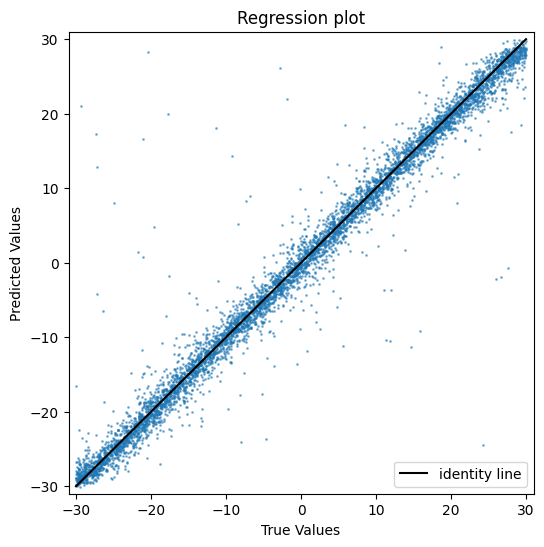

In [20]:
plt.figure(figsize=(6, 6))
plt.scatter(all_trues, all_preds, s=1, alpha=0.5)
plt.plot([-30, 30], [-30, 30], color='black', label='identity line')
plt.xlim(-31, 31)
plt.ylim(-31, 31)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Regression plot')
plt.legend()
plt.show()

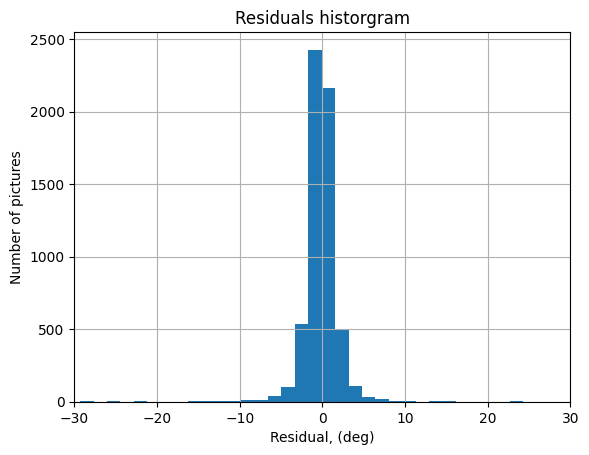

In [21]:
residuals = (all_preds - all_trues)

plt.hist(residuals, bins=61)
plt.xlim(-30, 30)
plt.title('Residuals historgram')
plt.xlabel('Residual, (deg)')
plt.ylabel('Number of pictures')
plt.grid(True)

### Анализ графика регрессии и гистограммы остатков

Модель стала горазо более точной чем бейзлайн, большинство изображений определяется с погрешностью не более двух градусов, однако некоторое количество выбросов на графике регрессии сохраняется

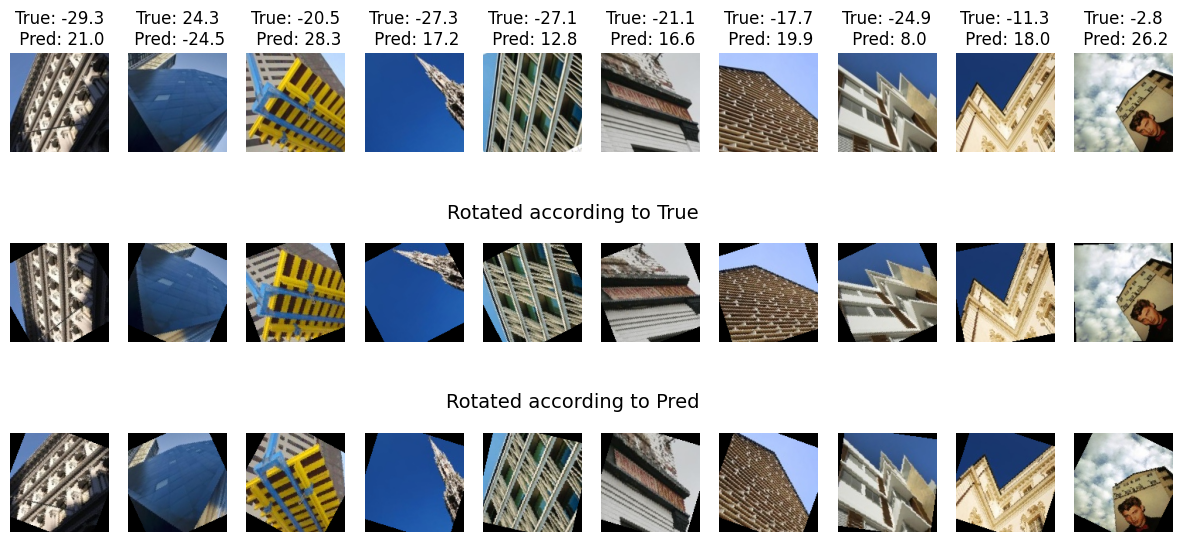

In [22]:
k = 10

top_errors = (all_trues - all_preds).abs().topk(k).indices

index = torch.tensor(dataset_test.subset.indices)[top_errors]

fig = plt.figure(figsize=(15, 7))
ax = fig.subplots(3, 10)


for i in enumerate(index):
    ax[0, i[0]].imshow(Image.open(f'data/images/{i[1]}.jpg'))
    ax[0, i[0]].axis('off')
    ax[0, i[0]].set_title(f'True: {all_trues[top_errors[i[0]]]:.1f}\n Pred: {all_preds[top_errors[i[0]]]:.1f}')
    
    ax[1, i[0]].imshow(Image.open(f'data/images/{i[1]}.jpg').rotate(-all_trues[top_errors[i[0]]]))
    ax[1, i[0]].axis('off')
    ax[2, i[0]].imshow(Image.open(f'data/images/{i[1]}.jpg').rotate(-all_preds[top_errors[i[0]]]))
    ax[2, i[0]].axis('off')

fig.text(0.5, 0.6, 'Rotated according to True', fontsize=14, horizontalalignment='center')
fig.text(0.5, 0.33, 'Rotated according to Pred', fontsize=14, horizontalalignment='center')

plt.show()

In [110]:
import shap

In [111]:
batch_size = 50
n_evals = 10000

masker_blur = shap.maskers.Image("blur(16,16)", (128, 128, 3))


def calc_torch(x):
    x1 = torch.tensor(x).permute((0, 3, 1, 2)).to('cuda')
    return model(x1)

explainer = shap.Explainer(calc_torch, masker_blur)

In [141]:
def vis_shap(ind):
    shap_values = explainer(
        dataset_test[ind][0].permute((1, 2, 0)).unsqueeze(0).numpy(),
        max_evals=n_evals,
        batch_size=batch_size,
    )
    
    shap.image_plot(
        shap_values=shap_values.values[0, :, :, :, 0].sum(axis=-1).reshape(128, 128, 1),
        pixel_values=shap_values.data[0] * 0.2 + 0.5,
    )
    
    print(f'Predicted: {model(dataset_test[ind][0].unsqueeze(0).to(device)).item():.2f}')
    print(f'True: {dataset_test[ind][1].item():.2f}')

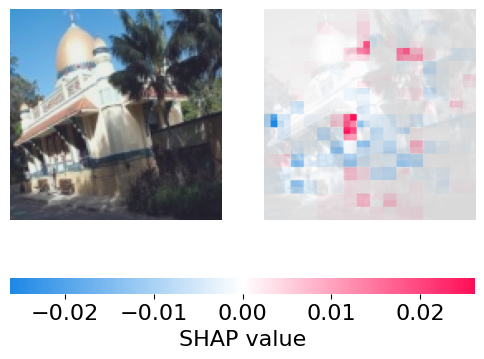

Predicted: -11.25
True: -10.80


In [142]:
vis_shap(3)

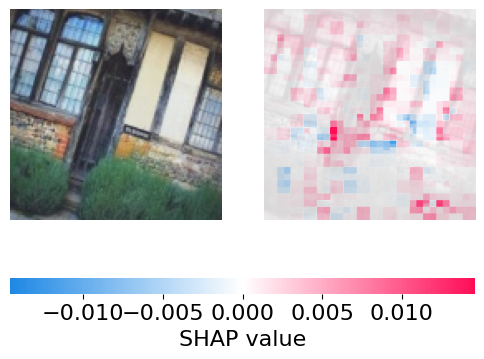

Predicted: 16.99
True: 17.17


In [143]:
vis_shap(10)

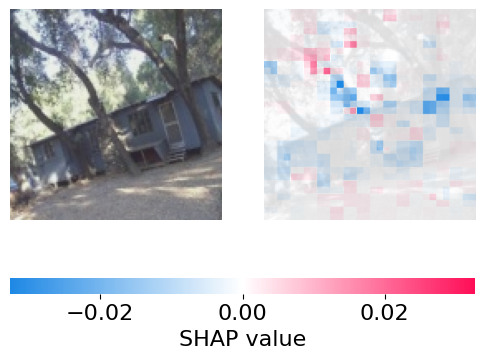

Predicted: -18.50
True: -15.67


In [144]:
vis_shap(1080)

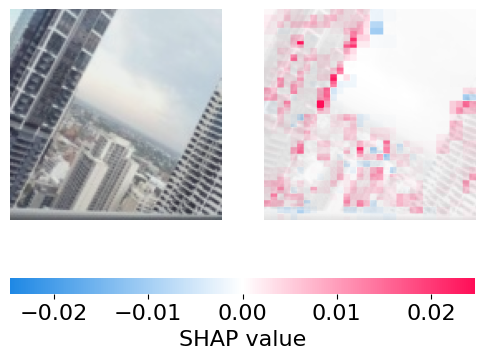

Predicted: 28.14
True: 27.25


In [145]:
vis_shap(1020)

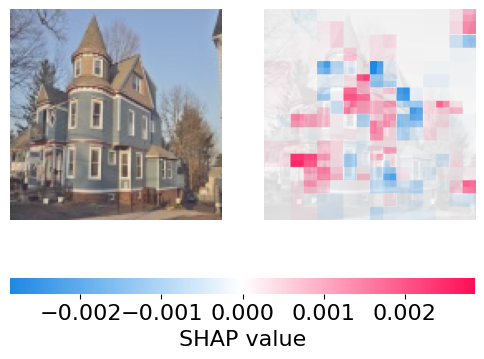

Predicted: 0.70
True: 0.93


In [146]:
vis_shap(5000)

## Результаты SHAP

Большое внимание модель уделяет границам с небом, если таковые имеются, а также длинным прямым линиям, при этом те линии которые изначально могут быть наклонными могут запутать модель (как на второй картинке)